In [1]:
using Revise
#push!(LOAD_PATH,"../src/")
using ProgressBars
using ITensors
using PastaQ
using RandomMeas

Precompiling RandomMeas
  ✓ RandomMeas
  1 dependency successfully precompiled in 5 seconds. 109 already precompiled.


In [2]:
N = 2
depth = 2
circuit    = randomcircuit(N, depth=depth)
noisemodel = (1 => ("depolarizing", (p = 0.02,)),2 => ("depolarizing", (p = 0.02,)))
noisemodel0 = (1 => ("depolarizing", (p = 0.0,)),2 => ("depolarizing", (p = 0.0,)))
Λ0 = runcircuit(circuit; process = true, noise = noisemodel0)
ξ0 = [firstind(Λ0[i],tags="Input",plev=0) for i in 1:N]
ξ20 = [firstind(Λ0[i],tags="Output",plev=0) for i in 1:N]
Λ = runcircuit(circuit; process = true, noise = noisemodel)
ξ = [firstind(Λ[i],tags="Input",plev=0) for i in 1:N]
ξ2 = [firstind(Λ[i],tags="Output",plev=0) for i in 1:N]
for i in 1:N
    Λ0[i] = replaceind(Λ0[i],ξ0[i],ξ[i])
    Λ0[i] = replaceind(Λ0[i],ξ0'[i],ξ'[i])
    Λ0[i] = replaceind(Λ0[i],ξ20[i],ξ2[i])
    Λ0[i] = replaceind(Λ0[i],ξ20'[i],ξ2'[i])
end
F = fidelity(Λ,Λ0)
println(" -- Process Fidelity ", F)

 -- Process Fidelity 0.960426666666663


In [5]:
nu = 4000
NM = 10000
states = ["Dn" for n in 1:N]
ψ  = MPS(ComplexF64,ξ,states)
ρ = outer(ψ',ψ)
data = zeros(Int8,(NM,N))
shadow = ITensor(vcat(ξ,ξ'))
Λs = ITensor(vcat(ξ,ξ',ξ2,ξ2'))
Λs_CRM = ITensor(vcat(ξ,ξ',ξ2,ξ2'))

P0 = state(ξ[1],"Dn")
for i in 2:N
    P0 *= state(ξ[i],"Dn")
end

Fs = zeros(Float64,nu)
Fs_CRM = zeros(Float64,nu)

for r in ProgressBar(1:nu, printing_delay=2)   
        ui = get_rotations(ξ,1) #Haar rotations in A
        uf = get_rotations(ξ,1) #Haar rotations in A
        ### Quantum Measurements
        ρu = apply(ui,ρ,apply_dag=true)
        ρe = runcircuit(ρu,circuit,noise=noisemodel)
        #Build shadow for the initial state
        uid = [dag(swapinds(ui[i],ξ[i],ξ[i]')) for i in 1:N]
        ρi = get_shadow(P0,ξ,uid)
        ρi = swapinds(ρi,ξ,ξ')

        #Build shadow for the final state
        data = get_RandomMeas(ρe,uf,NM)
        P = get_Born(data,ξ)
        ρf = get_shadow(P,ξ,uf)
        replaceinds!(ρf,ξ,ξ2)
        replaceinds!(ρf,ξ',ξ2')

        #Form process shadow
        Λt = 2^N*ρi*ρf
        Λs += Λt
        Fs[r] = real(inner(Λs,flatten(Λ0))/2^(2*N))/r
    
        #Repeat the same thing for simulated measurements
        σe = runcircuit(ρu,circuit,noise=noisemodel0)
        Pσ = get_Born(apply(uf,σe,apply_dag=true))
        σf = get_shadow(Pσ,ξ,uf)
        replaceinds!(σf,ξ,ξ2)
        replaceinds!(σf,ξ',ξ2')
        Λt_CRM = Λt-2^N*ρi*σf+flatten(Λ0)
        Λs_CRM += Λt_CRM
        Fs_CRM[r] = real(inner(Λs_CRM,flatten(Λ0))/2^(2*N))/r
end

0.0%┣                                             ┫ 0/4.0k [00:00<00:00, -0s/it]
0.0%┣                                         ┫ 1/4.0k [00:03<Inf:Inf, InfGs/it]
3.6%┣█▋                                         ┫ 145/4.0k [00:05<02:03, 31it/s]
7.8%┣███▍                                       ┫ 312/4.0k [00:07<01:19, 47it/s]
10.9%┣████▋                                     ┫ 436/4.0k [00:09<01:11, 50it/s]
14.4%┣██████                                    ┫ 575/4.0k [00:11<01:03, 54it/s]
18.3%┣███████▊                                  ┫ 731/4.0k [00:13<00:57, 58it/s]
21.7%┣█████████▏                                ┫ 869/4.0k [00:15<00:53, 59it/s]
25.7%┣██████████▌                              ┫ 1.0k/4.0k [00:17<00:48, 62it/s]
28.6%┣███████████▊                             ┫ 1.1k/4.0k [00:19<00:47, 61it/s]
30.8%┣████████████▋                            ┫ 1.2k/4.0k [00:21<00:46, 60it/s]
33.9%┣██████████████                           ┫ 1.4k/4.0k [00:23<00:44, 60it/s]
37.6%┣███████████████▍      

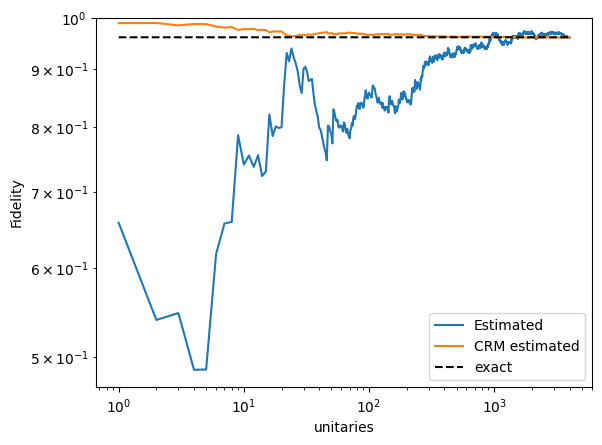

PyObject <matplotlib.legend.Legend object at 0x7f417fb69a10>

In [6]:
using PyPlot
plot(1:nu,Fs)
plot(1:nu,Fs_CRM)
plot(1:nu,F*ones(nu),"--k")
xscale("log")
yscale("log")
ylim(ymax=1)
ylabel("Fidelity")
xlabel("unitaries")
legend(["Estimated","CRM estimated","exact"])